<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#加载模型" data-toc-modified-id="加载模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>加载模型</a></span></li><li><span><a href="#准备数据" data-toc-modified-id="准备数据-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>准备数据</a></span></li><li><span><a href="#预测" data-toc-modified-id="预测-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>预测</a></span></li></ul></div>

# 加载模型

In [1]:
%matplotlib inline
import sys
sys.path.append(r'../02_algorithm/01_cnn')
from cnn_model import *
import pickle
import torch 
import numpy as np
sys.path.append('/home/liucc/Workspace/Ellipse/01_data')
from cc_process_image import *

data_path = r'/home/liucc/Workspace/Ellipse/03_results/01_industry/01_raw/'
model_path = r'/home/liucc/Workspace/Ellipse/06_model/'
model_name = r'ellipse'
    

# 准备数据

In [2]:
import sys
sys.path.append('/home/liucc/Workspace/Ellipse/01_data')
from cc_process_image import *

In [3]:
import os

names = os.listdir(f'{data_path}')
names = [n.split('.')[0] for n in names if n[-3:]=='jpg']
names.sort()
print(names[:10])

imxs = get_all_images(f'{data_path}',names,'jpg')
imxs = preprocess_images(imxs)


['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']


/home/liucc/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [4]:
from tqdm import tqdm_notebook as tqdm
from skimage.transform import rotate

width = 256
gap = 128

im_xs = []

for i,imx in tqdm(enumerate(imxs)):

    h,w = imx.shape
    
    for r in range(0,max(h-width,1),gap):
        for c in range(0,max(w-width,1),gap):
            
            r = max(min([r,h-width]),0)
            c = max(min([c,w-width]),0)
                
            xt = imx[r:r+width,c:c+width].astype(dtype=np.float32)
            
            x = np.zeros((width,width),dtype=np.float32)
            
            hx,wx = xt.shape
            
            x[:hx,:wx] = xt
            
            assert x.shape[0]==256 and x.shape[1]==256

            im_xs.append(x)

print(len(im_xs))


542


# 预测

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = RestoreNet().to(device)

model.load_state_dict(torch.load(f'{model_path}{model_name}.mdl')['state_dict'])

In [6]:
im_ys = []
for im in im_xs:
    im = np.expand_dims(np.expand_dims(im,0),0)
    im =  torch.tensor(im,dtype=torch.float32).to(device)
    outs = model(im)
    
    for i in range(len(outs)):
        if len(im_ys)<i+1:
            im_ys.append([])
        im_ys[i].append(outs[i].detach().cpu().numpy().squeeze())
     

In [7]:
print(len(im_ys))
print(len(im_ys[0]))
print(im_ys[0][0].shape)

8
542
(256, 256)


486
70
24
482
340
208
489
34
410
256


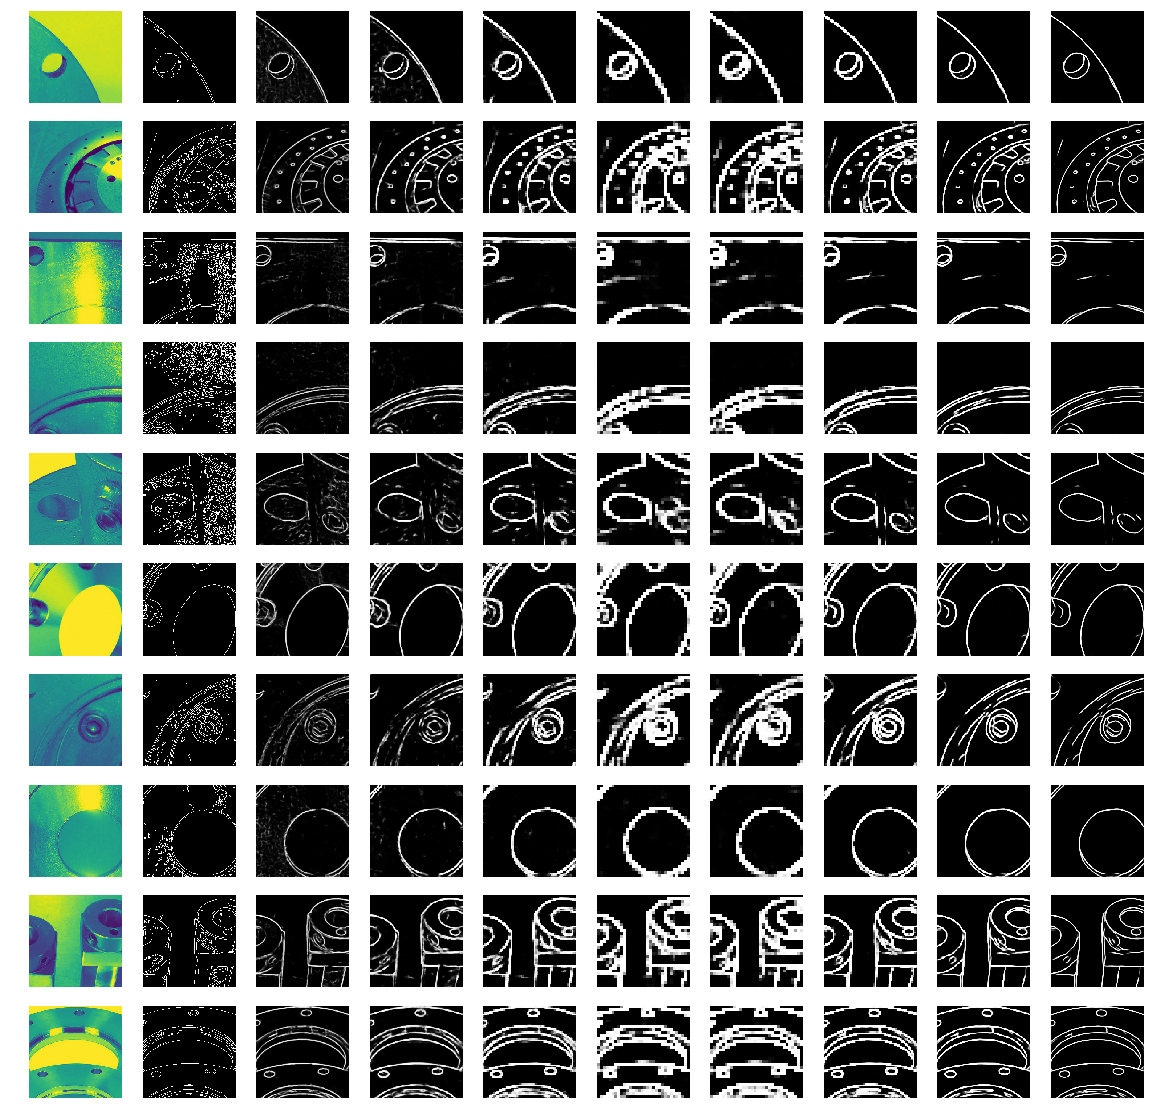

In [8]:
import matplotlib.pyplot as plt
from skimage.feature import canny

_,axes = plt.subplots(ncols=10,nrows=10,figsize=(20,20))

rind = np.random.permutation(len(im_xs))

for i,_id in enumerate(rind[:10]):
    imc = canny(im_xs[_id],sigma=1)
    print(_id)
    
    axes[i,0].imshow(im_xs[_id])
    axes[i,0].axis('off')
    axes[i,1].imshow(imc,cmap=plt.cm.gray, vmin=0, vmax=1)
    axes[i,1].axis('off')
    for j in range(8):
        axes[i,j+2].imshow(im_ys[j][_id],cmap=plt.cm.gray, vmin=0, vmax=1)
        axes[i,j+2].axis('off')
    
    
plt.show()

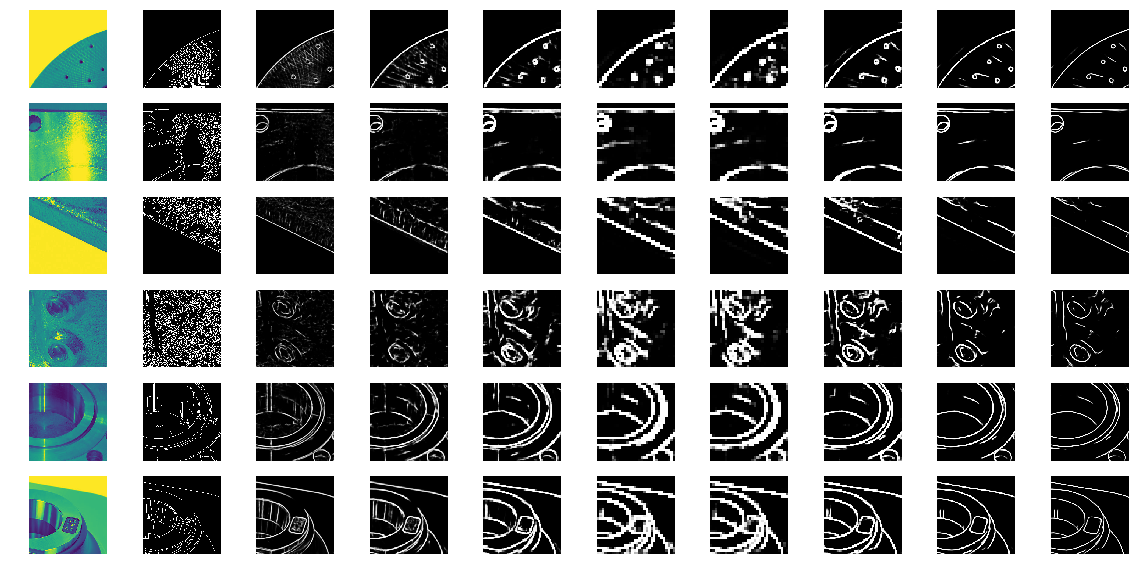

In [9]:
sid = [77,24,362,348,57,450]

_,axes = plt.subplots(ncols=10,nrows=len(sid),figsize=(20,10))

for i,_id in enumerate(sid):
    imc = canny(im_xs[_id],sigma=1)
    
    axes[i,0].imshow(im_xs[_id])
    axes[i,0].axis('off')
    axes[i,1].imshow(imc,cmap=plt.cm.gray, vmin=0, vmax=1)
    axes[i,1].axis('off')
    for j in range(8):
        axes[i,j+2].imshow(im_ys[j][_id],cmap=plt.cm.gray, vmin=0, vmax=1)
        axes[i,j+2].axis('off')
    
    
plt.show()

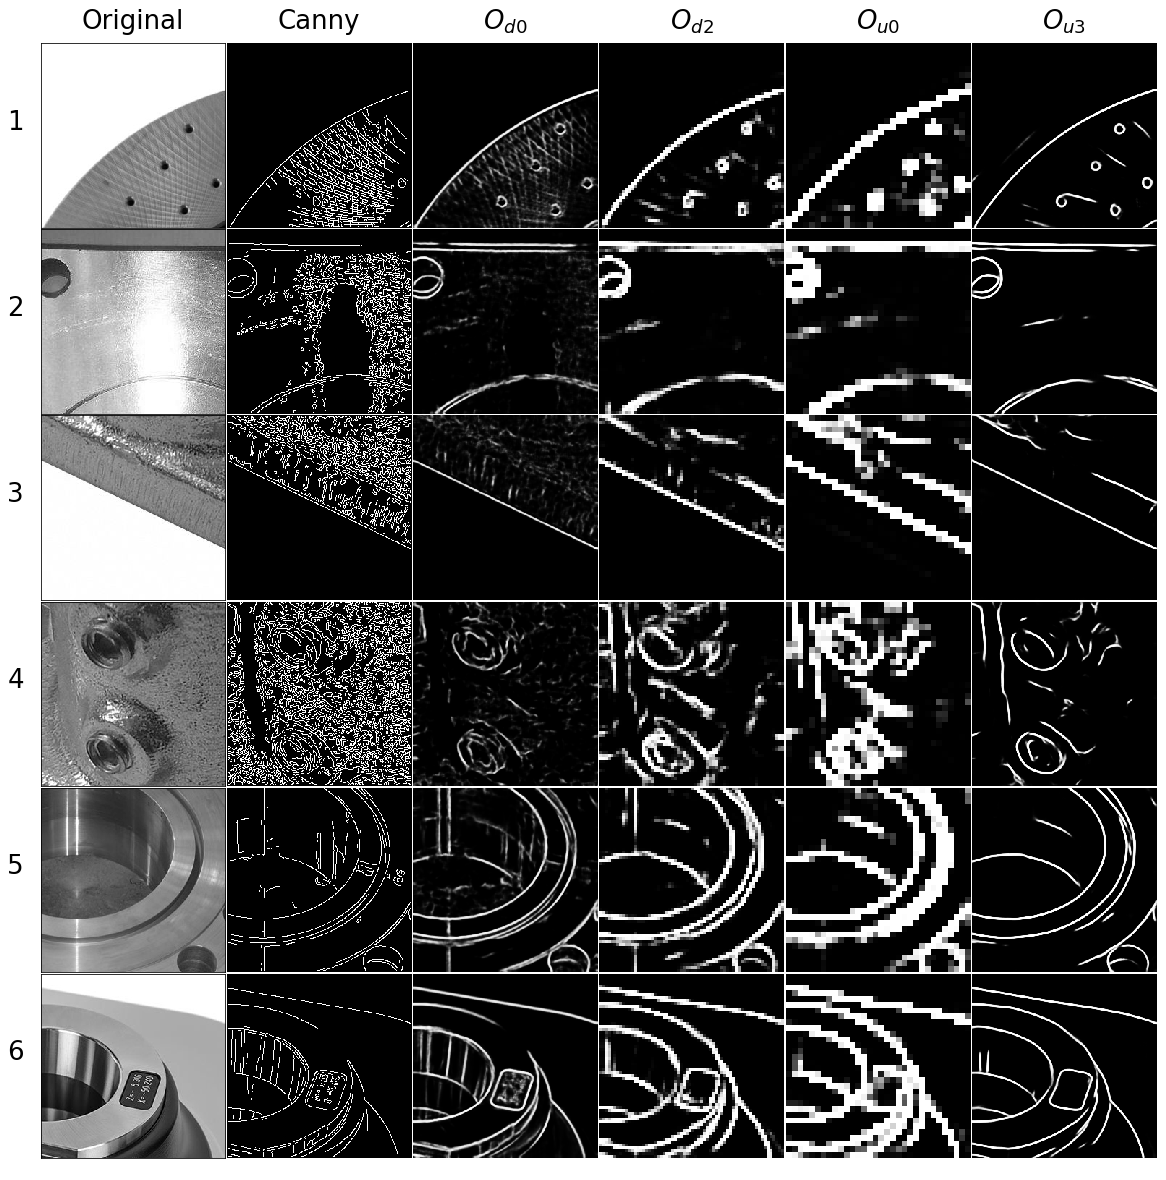

In [10]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pylab import *
from matplotlib import rcParams
rcParams['axes.titlepad'] = 15 

from matplotlib.font_manager import FontProperties
fp = FontProperties(family="DejaVu Sans",size=26)

titles = ['Original','Canny','$O_{d0}$','$O_{d2}$','$O_{u0}$','$O_{u3}$']
layers = [0,2,4,7]

fig = plt.figure(figsize=(20,20/len(titles)*len(sid)+0.5))
gs = gridspec.GridSpec(len(sid),len(titles),
                       wspace=0.01,
                       hspace=0.01,
                       width_ratios=[1]*len(titles),
                       height_ratios=[1]*len(sid),
                       )

for i,_id in enumerate(sid):
    
    _id = sid[i]
    
        
    ax = fig.add_subplot(gs[i,0])
    ax.imshow(im_xs[_id],cmap=plt.cm.gray, vmin=0, vmax=1)
    #ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel(str(i+1),fontproperties=fp,rotation=0,labelpad=25)
    if i==0:
        ax.set_title(titles[0],fontproperties=fp)
    
    imc = canny(im_xs[_id],sigma=1)
    ax = fig.add_subplot(gs[i,1])
    ax.imshow(imc,cmap=plt.cm.gray, vmin=0, vmax=1)
    ax.axis('off')
    if i==0:
        ax.set_title(titles[1],fontproperties=fp)
        
    for j,l in enumerate(layers):
        ax = fig.add_subplot(gs[i,j+2])
        ax.imshow(im_ys[l][_id],cmap=plt.cm.gray, vmin=0, vmax=1)
        ax.axis('off')
        if i==0:
            ax.set_title(titles[j+2],fontproperties=fp)
    
    

plt.show()

pp = PdfPages('images/intermediate.pdf')
pp.savefig(fig,dpi=300)
pp.close()